In [1]:
from concise.hyopt import CMongoTrials, get_data
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import data

%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

def print_exp(exp_name):
    print("-" * 40 + "\nexp_name: " + exp_name)


DIR_ROOT = "/s/project/deepcis/encode/eclip/"
DIR_ROOT = "/home/avsec/projects-work/deepcis/data/encode/eclip/"
RBP_LIST = ["UPF1", "PUM2", "DDX3X", "NKRF", "TARDBP", "SUGP2"]

DB_NAME = "RBP__Eclip"
HOST = "ouga03"
HOST = "localhost"

#EXPERIMENTS = ["DeepNN",
#               "DeepNN_scalar_position_gam",
#               "DeepNN_scalar_position_relu",
#               "DeepNN_track_position_gam",
#               "DeepNN_track_position_relu"]
EXPERIMENTS = ["DeepNN_2",
               "DeepNN_scalar_position_gam_2",
               "DeepNN_scalar_position_relu_2"]
data_fn = data.data


Using TensorFlow backend.


In [2]:
rbp = "UPF1"
def get_predictions_method(exp_name, data_fn, rbp_list=RBP_LIST):
    for rbp in rbp_list:
        # get trials
        c_exp_name = exp_name + "_" + rbp
        print_exp(c_exp_name)
        trials = CMongoTrials(DB_NAME, c_exp_name, ip=HOST, kill_timeout=30 * 60)

        # get best trial parameters
        tid = trials.best_trial_tid()
        param = trials.get_param(tid)

        # load_model
        m = trials.load_model(tid)

        # load_data
        train, valid, test = get_data(data_fn, param)

        # predict
        y_pred = m.predict(test[0], verbose=0)
        y_true = test[1]

        # save
        dt_pred = pd.DataFrame({"y_true": y_true.reshape((-1,)),
                                "y_pred": y_pred.reshape((-1,))})
        dt_pred.to_csv("{root}/processed/predictions/{rbp}/{method}.csv".
                       format(root=DIR_ROOT, rbp=rbp, method=exp_name))

## Conclusions & further TODO's

- [x] why is there such a big difference between eval performance and test performance?
  - that's ok. It's within the noise
- [ ] finish the partial-dependence plots

## TODO

- [/] inspect the hyper-parameters
  - [x] which internal position
  - [x] robustness accross models
  - [x] can you come up with a good hyper-param strategy for all the data?
  - [x] loss-curves for top 10
- make partial dependence plots
  - maybe there is a generic way to do this in keras?
- make final figure with description

- [/] deploy the fitting to the whole dataset
   - [x] gam
   - [ ] others?

## Inspect the hyper-parameters

In [23]:
def get_big_df(exp_name, rbp_list):
    df_list = [CMongoTrials(DB_NAME, exp_name + "_" + rbp, ip=HOST).as_df().assign(rbp=rbp) for rbp in tqdm(rbp_list)]
    return pd.concat(df_list)

In [24]:
all_df = pd.concat([get_big_df(exp_name, RBP_LIST).assign(exp=exp_name) for exp_name in EXPERIMENTS])

In [25]:
all_df

,eval.acc,eval.auc,eval.auprc,eval.loss,exp,loss,name.data,name.loss_metric,name.loss_metric_mode,name.model,param.data.n_bases,param.data.pos_as_track,param.data.pos_class_weight,param.data.rbp_name,param.data.scale_raw,param.data.test_chr,param.data.valid_chr,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.fit.use_weight,param.model.activation,param.model.dropout_rate,param.model.external_pos,param.model.external_pos.as_track,param.model.external_pos.scale,param.model.external_pos.type,param.model.external_pos.units,param.model.filters,param.model.internal_pos.name,param.model.internal_pos.pool_size,param.model.lr,param.model.use_batchnorm,param.shared.kernel_size,path.model,path.results,rbp,status,tid,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start
0,0.8238,0.8020,0.5548,0.4084,DeepNN_2,-0.5548,data,auprc,auprc,model,30,False,1.0,UPF1,True,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.0330,None,NaN,NaN,NaN,NaN,16,strided_maxpool,4,0.0004,False,11,/s/project/deepcis/hy...,/s/project/deepcis/hy...,UPF1,ok,3879,46.1098,266.1382,220.0284,2017-06-04 17:03:58.5...,2017-06-04 16:59:32.4...
1,0.8220,0.7925,0.5414,0.4098,DeepNN_2,-0.5414,data,auprc,auprc,model,20,False,1.0,UPF1,True,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.2069,None,NaN,NaN,NaN,NaN,16,strided_maxpool,4,0.0004,True,11,/s/project/deepcis/hy...,/s/project/deepcis/hy...,UPF1,ok,3880,38.8495,636.1002,597.2506,2017-06-04 17:10:08.8...,2017-06-04 16:59:32.7...
2,0.8225,0.7890,0.5344,0.4130,DeepNN_2,-0.5344,data,auprc,auprc,model,20,False,1.0,UPF1,True,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.1994,None,NaN,NaN,NaN,NaN,16,strided_maxpool,4,0.0007,True,11,/s/project/deepcis/hy...,/s/project/deepcis/hy...,UPF1,ok,3881,39.4462,564.3575,524.9113,2017-06-04 17:08:57.0...,2017-06-04 16:59:32.7...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,0.8560,0.8697,0.6661,0.3576,DeepNN_scalar_positio...,-0.6661,data,auprc,auprc,model,10,False,1.0,SUGP2,True,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.2298,NaN,False,log,relu,1.0,16,strided_maxpool,4,0.0023,False,11,/s/project/deepcis/hy...,/s/project/deepcis/hy...,SUGP2,ok,4776,16.4682,46.7265,30.2582,2017-06-04 23:23:20.7...,2017-06-04 23:22:33.9...
46,0.8506,0.8607,0.6458,0.3606,DeepNN_scalar_positio...,-0.6458,data,auprc,auprc,model,10,False,1.0,SUGP2,True,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.0473,NaN,False,log,relu,1.0,16,strided_maxpool,4,0.0039,False,11,/s/project/deepcis/hy...,/s/project/deepcis/hy...,SUGP2,ok,4777,17.3761,43.7182,26.3421,2017-06-04 23:23:20.5...,2017-06-04 23:22:36.7...
47,0.8557,0.8797,0.6683,0.3417,DeepNN_scalar_positio...,-0.6683,data,auprc,auprc,model,10,False,1.0,SUGP2,True,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.3218,NaN,False,log,relu,1.0,16,strided_maxpool,4,0.0009,False,11,/s/project/deepcis/hy...,/s/project/deepcis/hy...,SUGP2,ok,4778,18.1449,84.9821,66.8372,2017-06-04 23:24:14.3...,2017-06-04 23:22:49.3...


#### Internal position

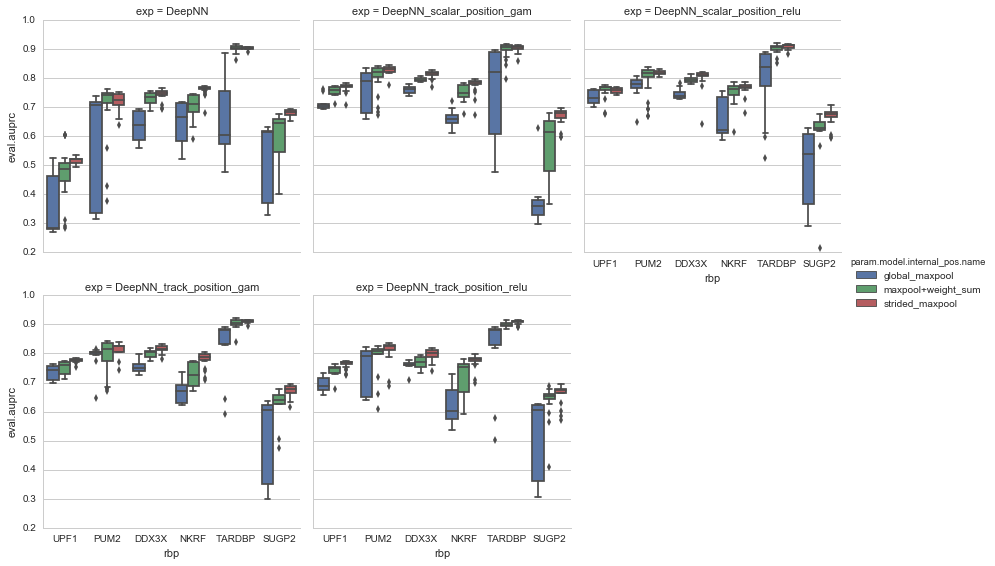

In [71]:
sns.factorplot(x="rbp", y="eval.auprc", hue="param.model.internal_pos.name",
               col="exp", col_wrap=3, data=all_df, kind="box")

Answer: Strided maxpooling

#### Number of bases

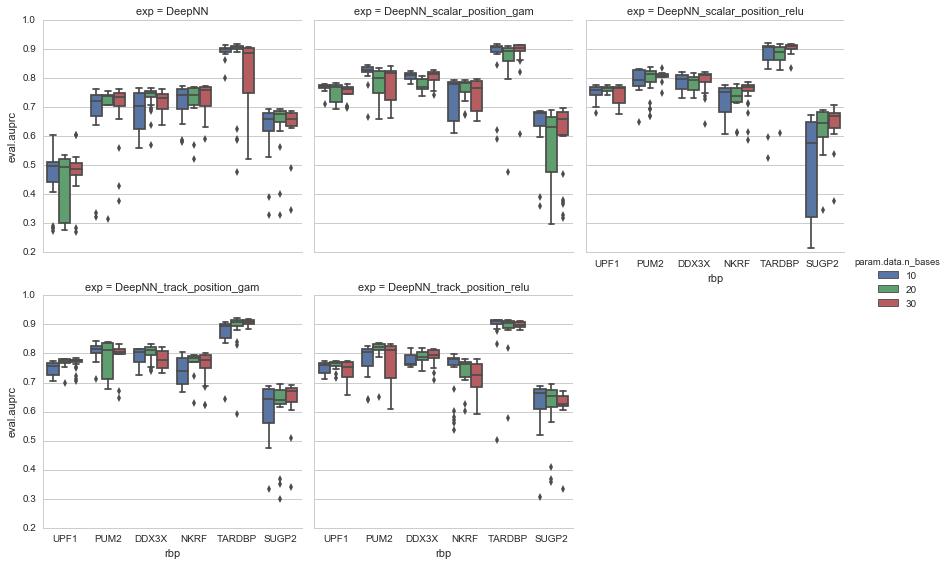

In [175]:
sns.factorplot(x="rbp", y="eval.auprc", hue="param.data.n_bases",
               col="exp", col_wrap=3, data=all_df, kind="box")

#### Use batchnorm?

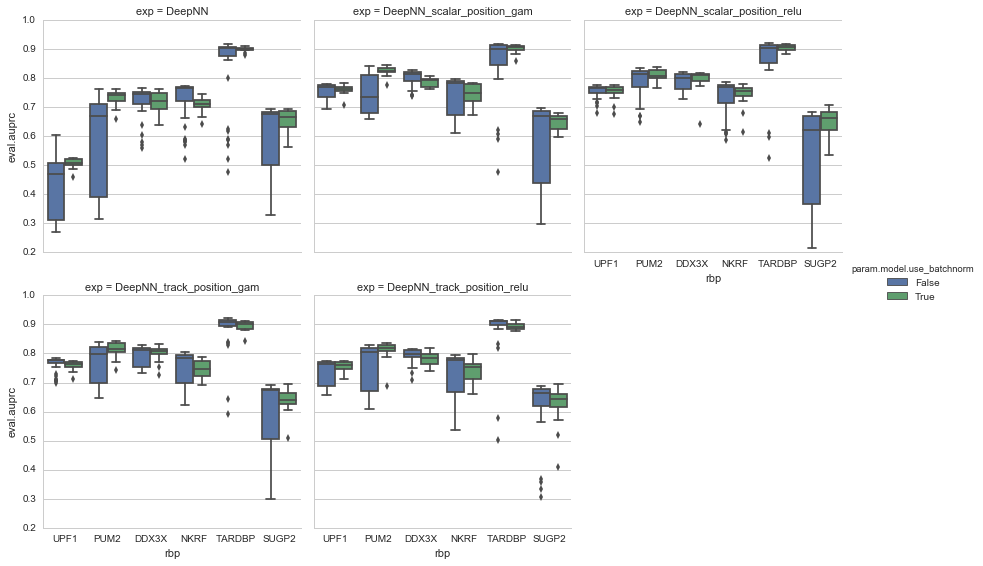

In [53]:
sns.factorplot(x="rbp", y="eval.auprc", hue="param.model.use_batchnorm",
               col="exp", col_wrap=3, data=all_df, kind="box")

#### Learning rate

In [65]:
all_df["param.model.log_lr"] = -np.log10(all_df["param.model.lr"])

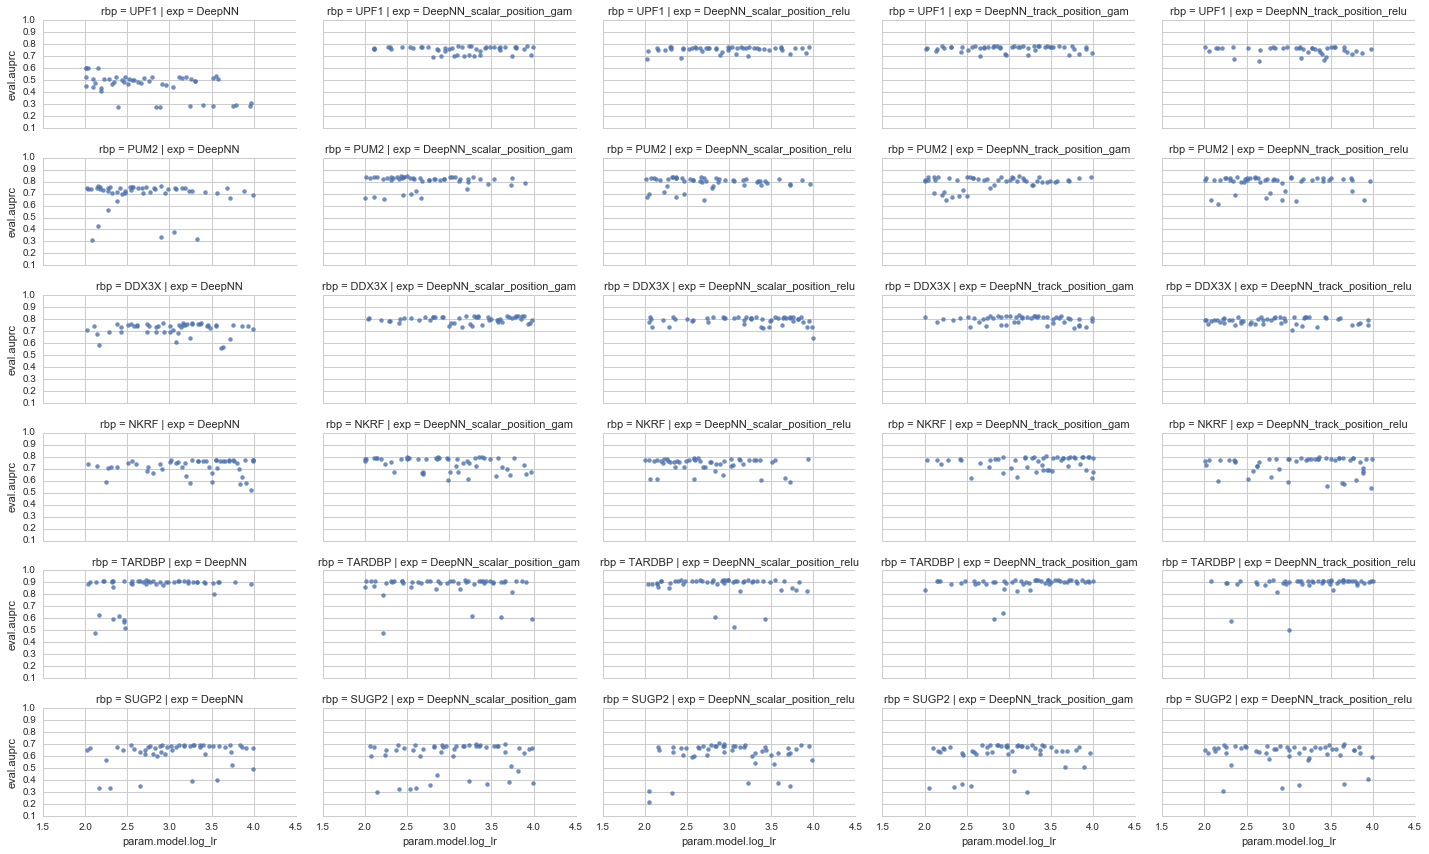

In [68]:
sns.lmplot(x="param.model.log_lr", y="eval.auprc",
           size=2, fit_reg=False, aspect=2,
           row="rbp", col="exp", data=all_df);

#### Dropout Rate

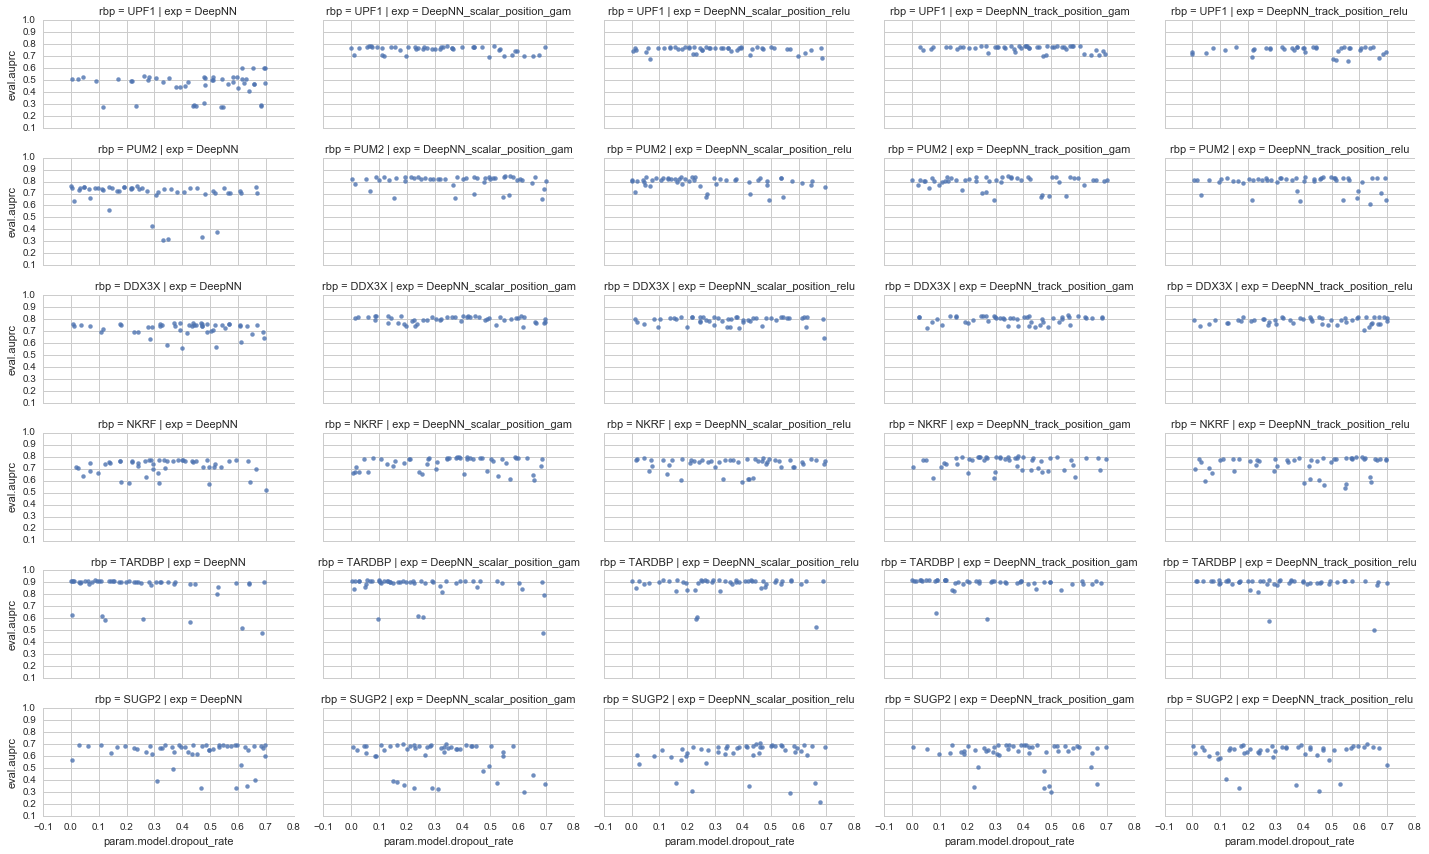

In [70]:
sns.lmplot(x="param.model.dropout_rate", y="eval.auprc",
           size=2, fit_reg=False, aspect=2,
           row="rbp", col="exp", data=all_df);

Using batchnorm allways helps

### Robustness accross models

All values:

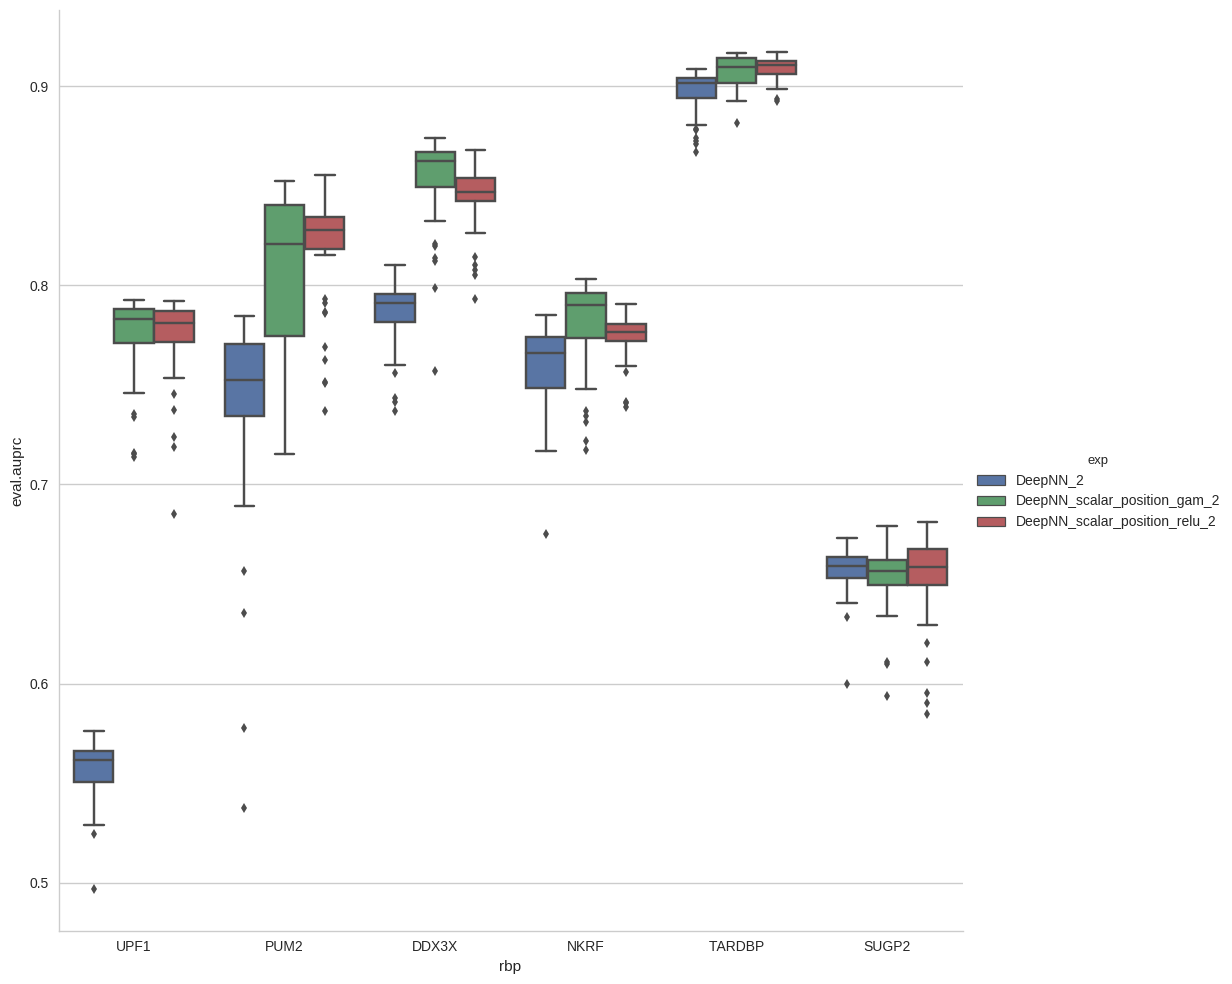

In [182]:
sns.factorplot(x="rbp", y="eval.auprc", hue="exp", data=all_df, size=10, kind="box");

Maximum values:

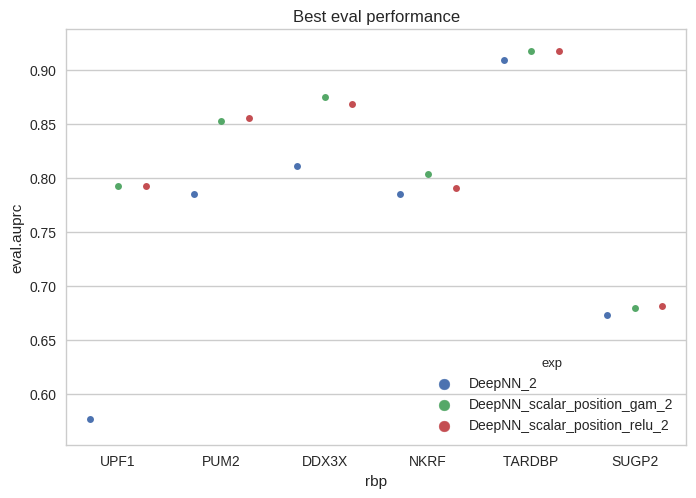

In [183]:
sns.stripplot(x = "rbp", split=True, hue="exp", 
              y = "eval.auprc", 
              data=all_df.groupby(["rbp", "exp"], sort=False)["eval.auprc"].max().reset_index())
plt.title("Best eval performance")

### Test predictions

In [185]:
dt_list = []
dt_pred_list = []
for rbp in RBP_LIST:
    for exp in EXPERIMENTS:
        path = "{root}/processed/predictions/{rbp}/{method}.csv".format(root=DIR_ROOT, rbp=rbp, method=exp)
        print(path)
        if os.path.exists(path):
            dt = pd.read_csv(path)
            del dt["Unnamed: 0"]
            dt["rbp"] = rbp
            dt["method"] = exp
            auc = cem.auc(dt["y_true"], dt["y_pred"])
            auprc = cem.auprc(dt["y_true"], dt["y_pred"])
            dtm = pd.DataFrame({"rbp": [rbp], "method": [exp], "auprc": [auprc], "auc": [auc]})
            dt_list.append(dtm)
            dt_pred_list.append(dt)

/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/UPF1/DeepNN_2.csv
/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/UPF1/DeepNN_scalar_position_gam_2.csv
/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/UPF1/DeepNN_scalar_position_relu_2.csv
/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/PUM2/DeepNN_2.csv
/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/PUM2/DeepNN_scalar_position_gam_2.csv
/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/PUM2/DeepNN_scalar_position_relu_2.csv
/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/DDX3X/DeepNN_2.csv
/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/DDX3X/DeepNN_scalar_position_gam_2.csv
/home/avsec/projects-work/deepcis/data/encode/eclip//processed/predictions/DDX3X/DeepNN_scalar_position_relu_2.csv
/home/avsec/projects-work/deepcis/dat

In [186]:
dt_test = pd.concat(dt_list)
dt_pred_test = pd.concat(dt_pred_list)

dt_pred_test.rbp = dt_pred_test.rbp.astype("category", categories=RBP_LIST, ordered=True)

In [187]:
dt_test

,auc,auprc,method,rbp
0,0.7903,0.5265,DeepNN_2,UPF1
0,0.9055,0.7671,DeepNN_scalar_positio...,UPF1
0,0.9044,0.7656,DeepNN_scalar_positio...,UPF1
...,...,...,...,...
0,0.8776,0.6846,DeepNN_2,SUGP2
0,0.8817,0.6882,DeepNN_scalar_positio...,SUGP2
0,0.8817,0.6864,DeepNN_scalar_positio...,SUGP2


In [188]:
dt_pred_test

,y_pred,y_true,rbp,method
0,0.1857,1.0,UPF1,DeepNN_2
1,0.3698,1.0,UPF1,DeepNN_2
2,0.4781,1.0,UPF1,DeepNN_2
...,...,...,...,...
5789,0.0046,0.0,SUGP2,DeepNN_scalar_positio...
5790,0.0074,0.0,SUGP2,DeepNN_scalar_positio...
5791,0.0750,0.0,SUGP2,DeepNN_scalar_positio...


In [189]:
dt_pred_test.groupby(["rbp", "method"]).apply(lambda g: cem.auc(g["y_true"], g["y_pred"])).reset_index()

,rbp,method,0
0,UPF1,DeepNN_2,0.7903
1,UPF1,DeepNN_scalar_positio...,0.9055
2,UPF1,DeepNN_scalar_positio...,0.9044
...,...,...,...
15,SUGP2,DeepNN_2,0.8776
16,SUGP2,DeepNN_scalar_positio...,0.8817
17,SUGP2,DeepNN_scalar_positio...,0.8817


In [190]:
def bootstrap(y_true, y_pred, metric, num_samples=200):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(y_true)
    idx = np.random.randint(0, n, (num_samples, n))
    return np.array([metric(y_true[idx[i]], y_pred[idx[i]]) 
                     for i in range(idx.shape[0])])

In [191]:
dt_pred_test

,y_pred,y_true,rbp,method
0,0.1857,1.0,UPF1,DeepNN_2
1,0.3698,1.0,UPF1,DeepNN_2
2,0.4781,1.0,UPF1,DeepNN_2
...,...,...,...,...
5789,0.0046,0.0,SUGP2,DeepNN_scalar_positio...
5790,0.0074,0.0,SUGP2,DeepNN_scalar_positio...
5791,0.0750,0.0,SUGP2,DeepNN_scalar_positio...


In [192]:
def bootstrap_group(g, metric):
    return pd.DataFrame({metric.__name__: bootstrap(g["y_true"], g["y_pred"], metric)})

In [193]:
dtb_auc = dt_pred_test.groupby(["rbp", "method"]).apply(lambda g: bootstrap_group(g, cem.auc)).reset_index()

In [194]:
dtb_auprc = dt_pred_test.groupby(["rbp", "method"]).apply(lambda g: bootstrap_group(g, cem.auprc)).reset_index()

In [199]:
# TODO - save the plots
dtb_auc.to_csv(DIR_ROOT + "/processed/predictions/bootstrap_auc.csv")
dtb_auprc.to_csv(DIR_ROOT + "/processed/predictions/bootstrap_auprc.csv")

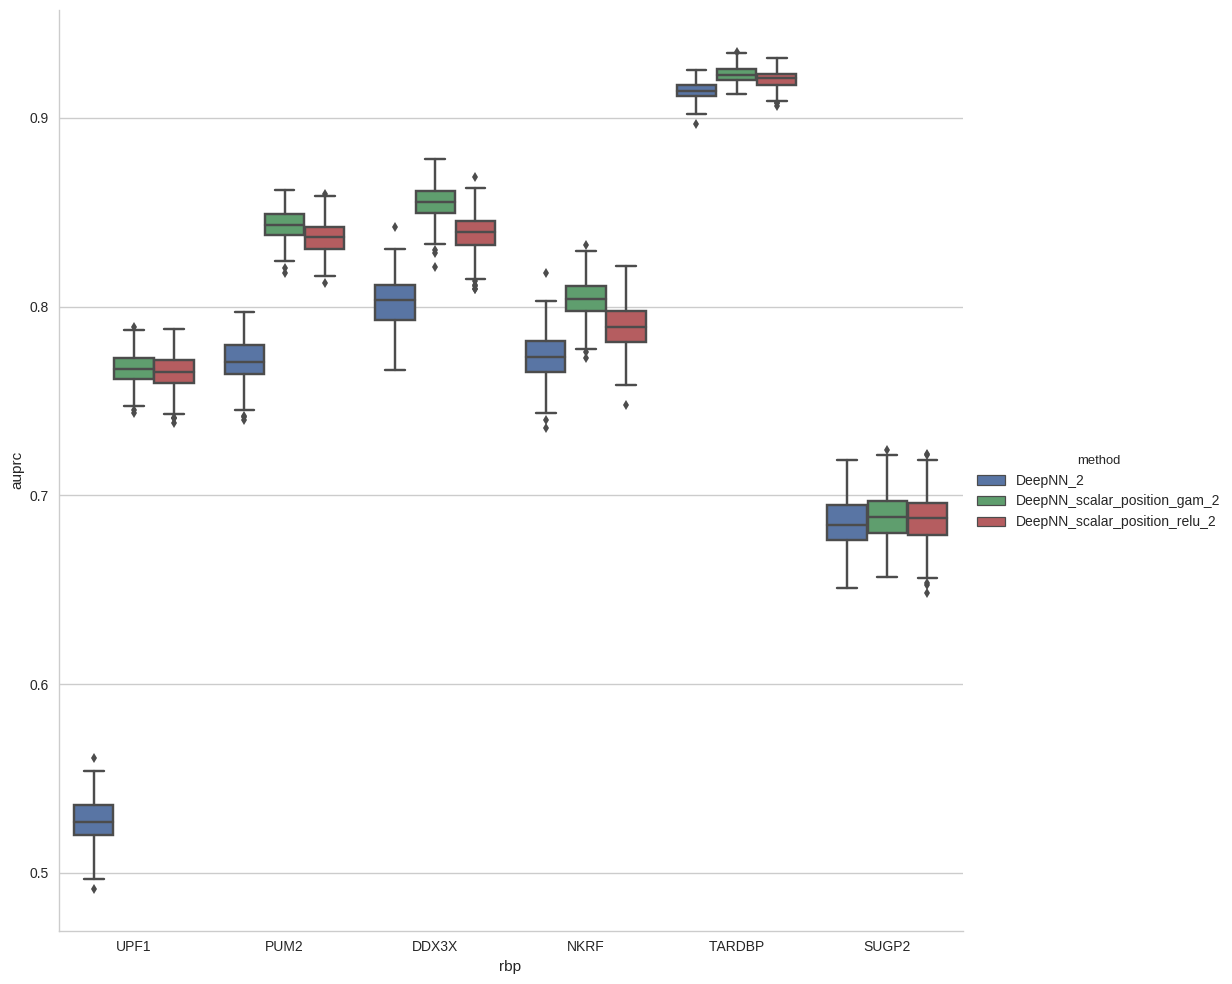

In [195]:
sns.factorplot(x="rbp", y="auprc", hue="method", data=dtb_auprc, size=10, kind="box");

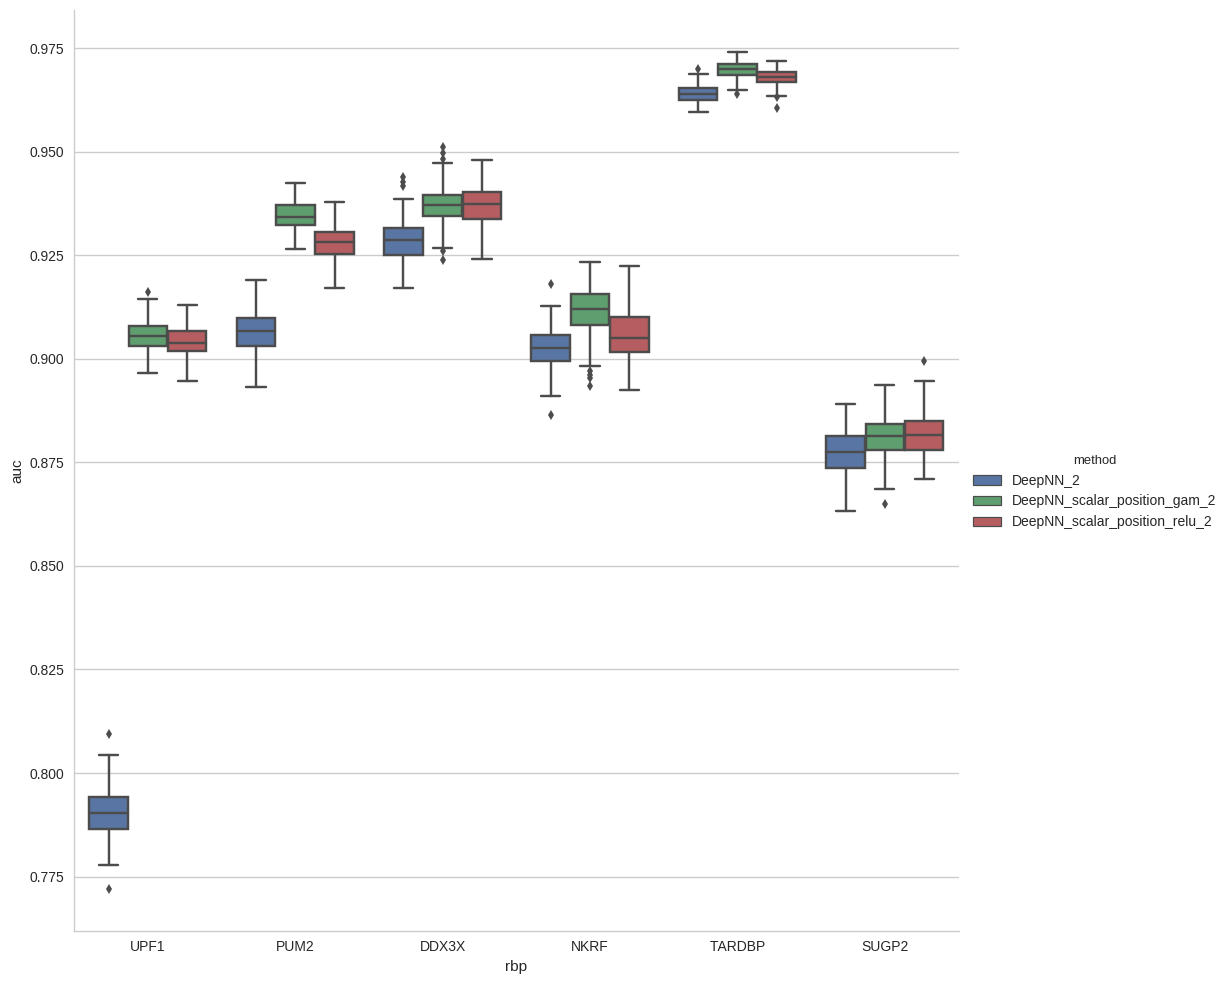

In [196]:
sns.factorplot(x="rbp", y="auc", hue="method", data=dtb_auc, size=10, kind="box");

In [159]:
dtb_auprc

,rbp,method,level_2,auprc
0,DDX3X,DeepNN_2,0,0.8029
1,DDX3X,DeepNN_2,1,0.8135
2,DDX3X,DeepNN_2,2,0.8102
...,...,...,...,...
3597,UPF1,DeepNN_scalar_positio...,197,0.7666
3598,UPF1,DeepNN_scalar_positio...,198,0.7602
3599,UPF1,DeepNN_scalar_positio...,199,0.7449


In [22]:
import os

In [31]:
import concise.eval_metrics as cem

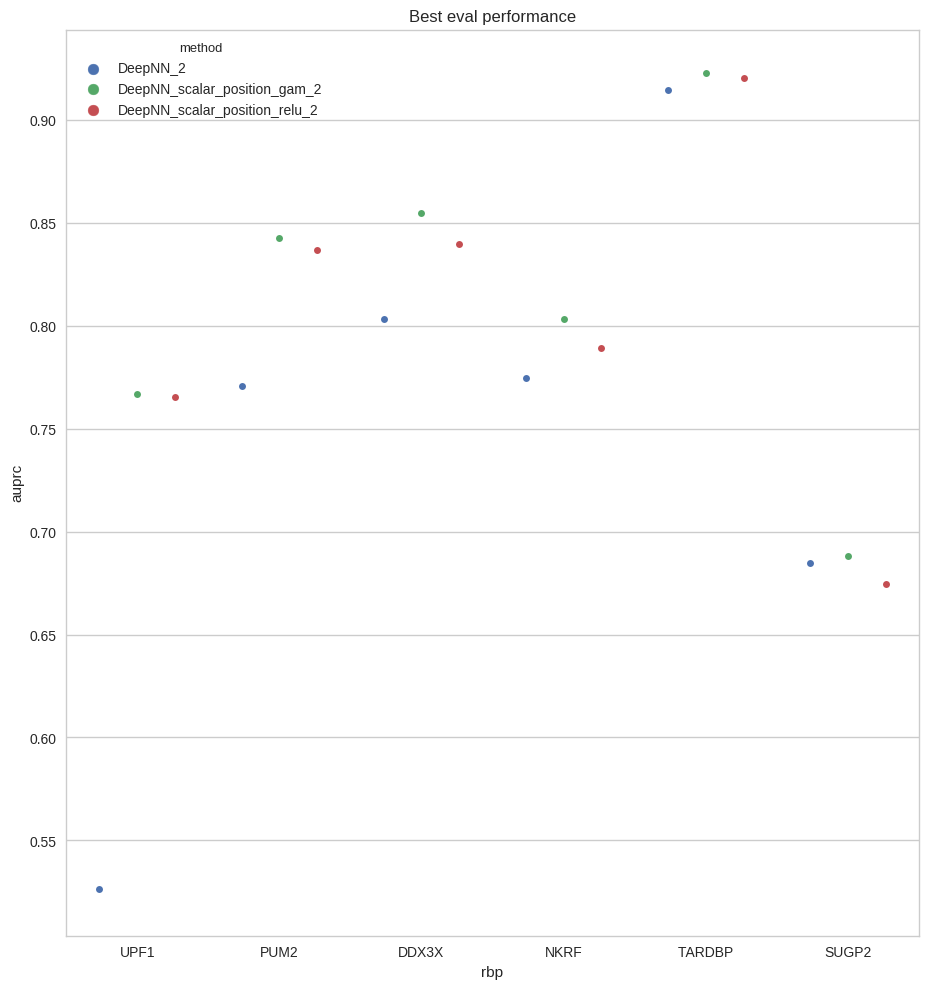

In [77]:
sns.stripplot(x = "rbp", split=True, hue="method", y = "auprc", 
              data=dt_test)
plt.title("Best eval performance")

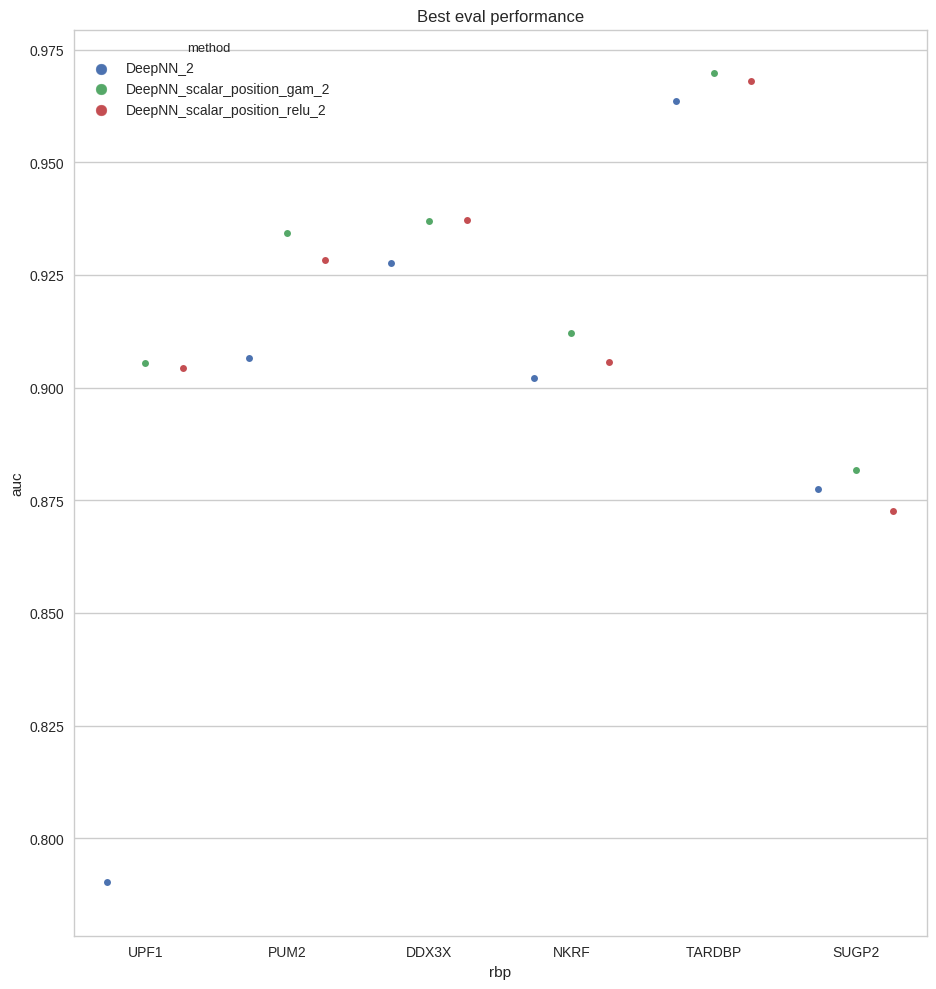

In [158]:
sns.stripplot(x = "rbp", split=True, hue="method", 
              y = "auc", data=dt_test)
plt.title("Best eval performance")

## Conclusions

Somethow, the validation set and the test set are too different from each other, especially for the UPF1

See: [main](https://i12g-gagneurweb.in.tum.de/project/deepcis/#Scripts_RBP_Eclip_main.html)

### Loss curves for the top-10 cases

In [9]:
def get_top10_losses(exp, rbp, top_n=20):
    trials = CMongoTrials(DB_NAME, exp + "_" + rbp, ip=HOST)
    loss_list = [trials.train_history(trials.best_trial_tid(i)).assign(rank=i) for i in range(top_n)]
    df = pd.concat(loss_list)
    df["exp"] = exp
    df["rbp"] = rbp
    return df

In [11]:
hist_df = pd.concat([get_top10_losses(exp, rbp) for exp in EXPERIMENTS for rbp in RBP_LIST])

In [147]:
hist_df.to_csv(DIR_ROOT + "/processed/top_loss_curves.csv")

In [12]:
hist_df.head()

,tid,epoch,acc,loss,val_acc,val_loss,rank,exp,rbp
0,3919,0,0.7942,0.4924,0.8121,0.4385,0,DeepNN_2,UPF1
1,3919,1,0.8072,0.4408,0.8154,0.4244,0,DeepNN_2,UPF1
2,3919,2,0.8130,0.4309,0.8183,0.4161,0,DeepNN_2,UPF1
3,3919,3,0.8148,0.4246,0.8225,0.4132,0,DeepNN_2,UPF1
4,3919,4,0.8172,0.4195,0.8231,0.4081,0,DeepNN_2,UPF1


In [13]:
BY = ["exp", "rbp", "epoch"]
df_summary = hist_df[hist_df["rank"]< 10][["val_loss"] + BY].groupby(BY).mean().reset_index()
df_summary.rbp = df_summary.rbp.astype("category", categories=RBP_LIST, ordered=True)

In [14]:
from ggplot import *

In [157]:
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = "11, 12" # or  whatever you want

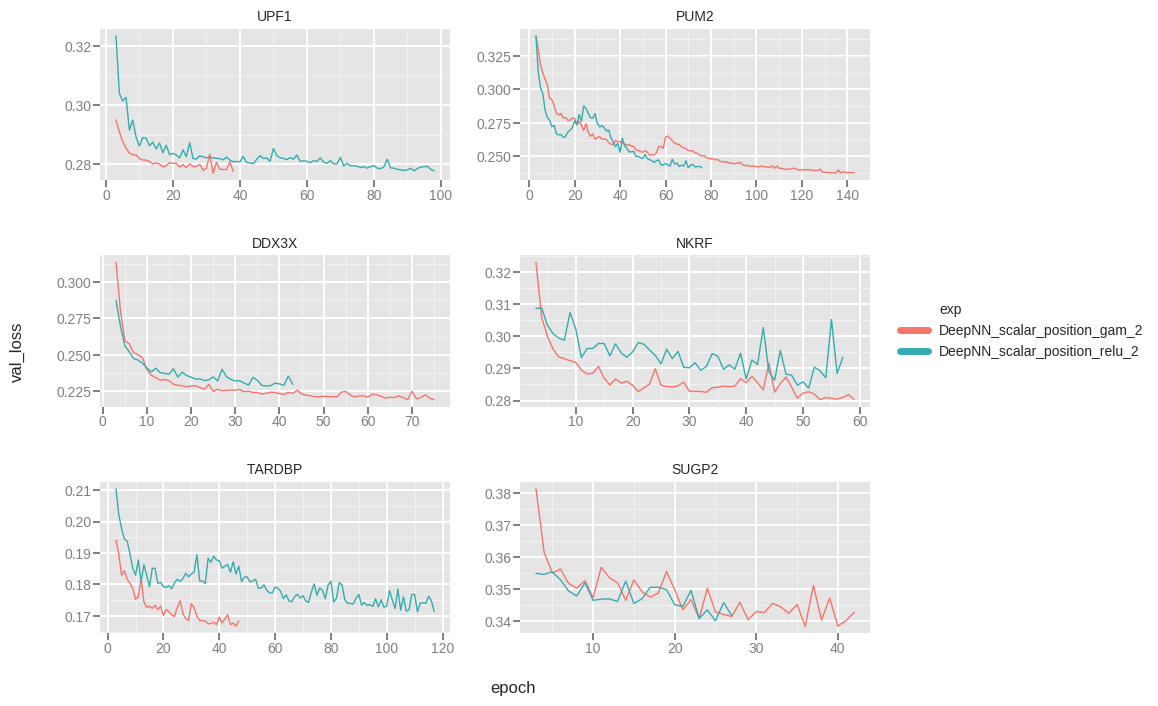

<ggplot: (-9223363277614230454)>

In [16]:
ggplot(aes(x="epoch", y="val_loss", color="exp"), 
       df_summary[(df_summary.epoch > 2) & df_summary.exp.str.contains("scalar")]) + \
    geom_line() + \
    facet_wrap("rbp", scales="free")

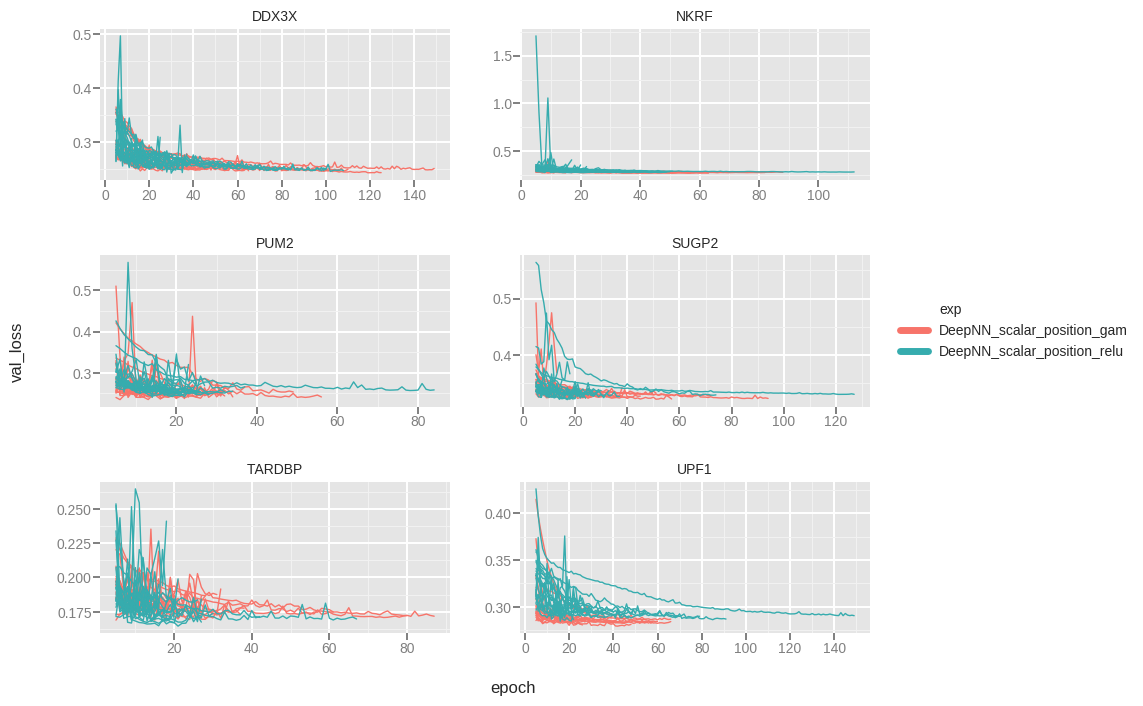

<ggplot: (-9223363250195922232)>

In [155]:
ggplot(aes(x="epoch", y="val_loss", color="exp", group="rank"), 
       hist_df[(hist_df.epoch > 4) & hist_df.exp.str.contains("scalar")]) + \
    geom_line() + \
    facet_wrap("rbp", scales="free")

***Conclusions*** - we should show the loss curves only for the positional RBP's

### Inspect the internal position partial dependence plots

In [ ]:
## TODO

## Partial dependence plots for the position

- TODO - wrap this code into general plots -> reuse code from branchsite

In [3]:
rbp_name = "UPF1"

In [4]:
## TODO 

In [5]:
def get_best_model(rbp, exp_name):
    trials = CMongoTrials(DB_NAME, exp_name + "_" + rbp, ip=HOST)
    tid = trials.best_trial_tid()
    param = trials.get_param(tid)
    return trials.load_model(tid), param

In [6]:
from concise.hyopt import get_data

In [7]:
m, param = get_best_model(rbp_name, EXPERIMENTS[1])

In [2]:
train, valid, test = get_data(data.data, param)
tss_pos_ranges, polya_pos_ranges = train[3:5]

NameError: name 'get_data' is not defined

In [1]:
train[0]

NameError: name 'train' is not defined

In [18]:
print(tss_pos_ranges)
print(polya_pos_ranges)

NameError: name 'tss_pos_ranges' is not defined

In [8]:
def get_new_train(train, xr, which):
    from copy import deepcopy
    def get_new_train_one(i, train, xr, which):
        xtrain = deepcopy(train)
        xrval = xr[i][np.newaxis]
        xrval = np.repeat(xrval, train[1].shape[0], axis=0)
        xtrain[0][which] = xrval
        return xtrain
    return [get_new_train_one(i, train, xr, which) for i in range(xr.shape[0])]

In [13]:
def get_predictions(rbp, exp_name, num_eval=50):
    from concise.preprocessing import encodeSplines
    from copy import deepcopy
    print("get model")
    m, param = get_best_model(rbp_name, exp_name)
    print("get data")
    train, valid, test = get_data(data.data, param)
    tss_pos_ranges, polya_pos_ranges = train[3:5]
    
    ## TODO - change this back to 0,1 range and then back to -min, max range
    #tss_xr = np.linspace(np.log10(tss_pos_ranges["min"]), np.log10(tss_pos_ranges["max"]), num=num_eval)
    tss_xr = np.linspace(0, 1, num=num_eval)
    #polya_xr = np.linspace(np.log10(polya_pos_ranges["min"]), np.log10(polya_pos_ranges["max"]), num=num_eval)
    polya_xr = np.linspace(0, 1, num=num_eval)

    print("process positions")    
    pos_type=exp_name.split("_")[-2]
    if pos_type == "gam":
        which_tss = "dist_tss_log"
        which_polya= "dist_polya_log"
        n_bases = train[0]["dist_tss_nat"].shape[2]
        tss_xr_feat = encodeSplines(tss_xr, n_bases=n_bases, start = 0, end = 1)
        polya_xr_feat = encodeSplines(polya_xr, n_bases=n_bases, 
                                      start = 0, end = 1)
    elif pos_type == "relu":
        which_tss = "raw_dist_tss_log"
        which_polya= "raw_dist_polya_log"
        tss_xr_feat = tss_xr[:, np.newaxis, np.newaxis]
        polya_xr_feat = polya_xr[:, np.newaxis, np.newaxis]
    else:
        raise Exception
    
    print("get tss data")
    tss_train_list = get_new_train(train, tss_xr_feat, which_tss)
    print("get polya data")
    polya_train_list = get_new_train(train, polya_xr_feat, which_polya)
    
    print("predict for tss")
    tss_preds = np.stack([m.predict(train_xp[0]) for train_xp in tss_train_list])
    print("predict for polya")
    polya_preds = np.stack([m.predict(train_xp[0]) for train_xp in polya_train_list])
    
    df = pd.DataFrame({"tss_x": tss_xr,
                  "tss_y": tss_preds.mean(1).reshape((-1)),
                  "polya_x": polya_xr,
                  "polya_y": polya_preds.mean(1).reshape((-1)),
                 })
    return df

        
    

In [ ]:
df_gam = get_predictions("UPF1", EXPERIMENTS[1], 50)
df_relu = get_predictions("UPF1", EXPERIMENTS[2], 50)

get model
get data
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
WARNING, x.max() > end for some elements. Truncating them to end: x[x > end] = end
process positions
get tss data
get polya data
predict for tss
predict for polya


KeyboardInterrupt: 

In [ ]:
dt_pos_all = pd.concat([get_predictions(rbp, exp, 50).assign(rbp=rbp, exp=exp) 
                         for rbp in tqdm(RBP_LIST) 
                         for exp in tqdm(EXPERIMENTS[1:3])])

In [ ]:
EXPERIMENTS[1:2]

In [ ]:
## TODO - debug this plots

In [182]:
EXPERIMENTS

['DeepNN',
 'DeepNN_scalar_position_gam',
 'DeepNN_scalar_position_relu',
 'DeepNN_track_position_gam',
 'DeepNN_track_position_relu']

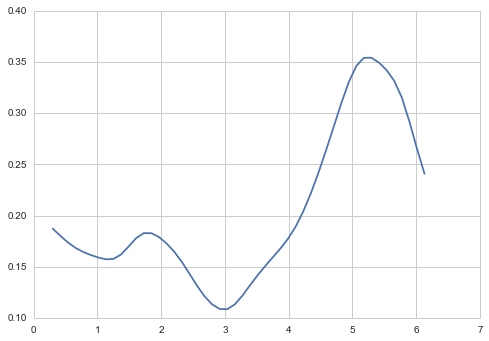

In [170]:
plt.plot(tss_xr, preds.mean(1))